<h1 align='center'>Report - Capstone Project - The Battle of Neighborhoods (Week 5)</h1>

<h2 align='center'>A. Introduction/Business Problem</h2>

Problem Statement:  RecoWeb a recommendation website wants to offer a new type of feature that helps its users in categorizing the nearby eateries in major cities of the world with respect to uniqueness of cuisines and help tourists complete their tour without missing anything on the culinary side of things. 

Stakeholders: RecoWeb 

Target Audience: People touring these cities and looking for unique cuisines.

<h2 align='center'>B. Data</h2>

We would be using two sets of data to solve our problem

1. World Cities Dataset

This dataset helps us locating the cities with their latitudes and longitudes. We use this to standerize our city names and focus on only ~26000 major cities in the world.We do this to ensure that our analysis does not corrupt due two cities having similar names.

2. Foursquare API Query

We use the explore query to get unique eatries nearby the city center within a 5 km radius. We then cluster them into groups and present them to the user wholly as a group to choose from./

A brief overview and examples of data are given below.

<b>1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim
import folium

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

<b>1. Importing World cities dataset aquired from https://simplemaps.com/data/world-cities

In [2]:
cities=pd.read_csv(r'D:\Datasets\worldcities.csv')
cities.shape

(26569, 11)

In [3]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


<b>2. Taking the City Name as Input. Lets take Mumbai for example

In [4]:
city=input('Input ascii compatible city name with first letter in uppercase: ')
print('Searching for city {} '.format(city))

while (city not in cities['city_ascii'].to_list()):
    print(city)
    print('Name not found in database')
    print('Enter 1 to try again')
    print('Enter 0 to exit')
    aux=int(input())
    if aux==1:
        city=input('Input ascii compatible city name with first letter in uppercase: ')
        print('Searching for city {} '.format(city))
    if aux==0:
        raise KeyboardInterrupt

print('City found')

Input ascii compatible city name with first letter in uppercase: Mumbai
Searching for city Mumbai 
City found


In [5]:
idx=cities[cities['city_ascii']==city].index.values

city_latitude = cities.loc[idx[0], 'lat'] # city latitude value
city_longitude = cities.loc[idx[0], 'lng'] # city longitude value

city_name = cities.loc[idx[0], 'city_ascii'] # city name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Mumbai are 18.9667, 72.8333.


<b>2. Initializing Foursquare Attributes

In [7]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

<b>3. Getting eateries categorized as food

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
radius = 5000
section='food'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT,
    section)

In [10]:
res = requests.get(url).json()

In [11]:
#res

In [12]:
venues = res['response']['groups'][0]['items']
    
nearby_venues_food = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_food =nearby_venues_food.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_food['venue.categories'] = nearby_venues_food.apply(get_category_type, axis=1)

# clean columns
nearby_venues_food.columns = [col.split(".")[-1] for col in nearby_venues_food.columns]

nearby_venues_food.head()

,name,categories,lat,lng
0,Sarvi,Middle Eastern Restaurant,18.966853,72.829221
1,Jaffer Bhai's Delhi Darbar,Indian Restaurant,18.961417,72.823379
2,Al Rehmani,Indian Restaurant,18.961843,72.831818
3,Shalimar Restaurant,Indian Restaurant,18.958180,72.832367
4,Shree Thaker Bhojnalay,Indian Restaurant,18.951217,72.828326


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues_food.shape[0]))

50 venues were returned by Foursquare.


<b>4. Getting eateries categorized as coffee

In [16]:
radius = 5000
section='coffee'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT,
    section)

In [17]:
res = requests.get(url).json()

In [18]:
venues = res['response']['groups'][0]['items']
    
nearby_venues_cofee = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_cofee =nearby_venues_cofee.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_cofee['venue.categories'] = nearby_venues_cofee.apply(get_category_type, axis=1)

# clean columns
nearby_venues_cofee.columns = [col.split(".")[-1] for col in nearby_venues_cofee.columns]

nearby_venues_cofee.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,18.956426,72.812065
1,Kyani & Co.,Café,18.944062,72.828576
2,Starbucks,Coffee Shop,18.932190,72.833959
3,Food for Thought,Café,18.932031,72.831667
4,Le 15 Patisserie,Cupcake Shop,18.995091,72.823735


In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues_cofee.shape[0]))

50 venues were returned by Foursquare.


<b>5. Getting eateries categorized as drinks

In [19]:
radius = 5000
section='drinks'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT,
    section)

In [20]:
res = requests.get(url).json()

In [21]:
venues = res['response']['groups'][0]['items']
    
nearby_venues_drinks = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_drinks =nearby_venues_drinks.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_drinks['venue.categories'] = nearby_venues_drinks.apply(get_category_type, axis=1)

# clean columns
nearby_venues_drinks.columns = [col.split(".")[-1] for col in nearby_venues_drinks.columns]

nearby_venues_drinks.head()

,name,categories,lat,lng
0,Tote On The Turf,Nightclub,18.980266,72.820294
1,Gallops,Restaurant,18.981231,72.817178
2,Doolally Taproom,Brewery,18.963809,72.807695
3,The Irish House,Pub,18.994416,72.824721
4,Aer Four Seasons Hotel,Lounge,18.994132,72.820377


In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues_drinks.shape[0]))

50 venues were returned by Foursquare.


<b>6. Merging All three Datasets and removing duplicates

In [23]:
nearby_venues=nearby_venues_food.append(nearby_venues_cofee)
nearby_venues=nearby_venues.append(nearby_venues_drinks)

In [24]:
nearby_venues=nearby_venues.drop_duplicates()

In [25]:
nearby_venues[:]

,name,categories,lat,lng
0,Sarvi,Middle Eastern Restaurant,18.966853,72.829221
1,Jaffer Bhai's Delhi Darbar,Indian Restaurant,18.961417,72.823379
2,Al Rehmani,Indian Restaurant,18.961843,72.831818
3,Shalimar Restaurant,Indian Restaurant,18.958180,72.832367
4,Shree Thaker Bhojnalay,Indian Restaurant,18.951217,72.828326
...,...,...,...,...
45,The Local,Gastropub,18.929855,72.831383
46,Alps Restaurant & Beer Bar,Bar,18.922578,72.832583
47,Playboy,Nightclub,19.005584,72.826455
48,Café Ideal,Indian Restaurant,18.955732,72.812887


We will use this data to cluster the shops and provide the categories of eatries to the customers

<h2 align='center'>C. Methodology</h2>

    1.Users will be asked to input a city of their choice.
    
    2. We will first find out latitude and longitude for our city using a world cities dataset.

    (Dataset attributed to : https://simplemaps.com/data/world-cities )

    2. Then we will be using Four Square’s API to find out all eateries within a 5 km radius of the city center.
        
        The type of categories available are:
        
        a. Food
        b. Coffee
        c. Drinks
        
    3. We then clean our data to remove any duplicates that may have arisen due to overlap of categories.
        
    4. We then one hot encode the data to make it suitable for simplified clustering.

    5. We then use k means clustering to find similarities and dissimilarities between eateries. 
    
    6. Finally using Folium we display the results for each city.
    
    7. In the end we output dataframes pertaining to various categories to educate user about all the different 
       choices available to them in that particular city

<h2 align='center'>D. Results</h2>

Below are the results of running the code for the city of Mumbai.

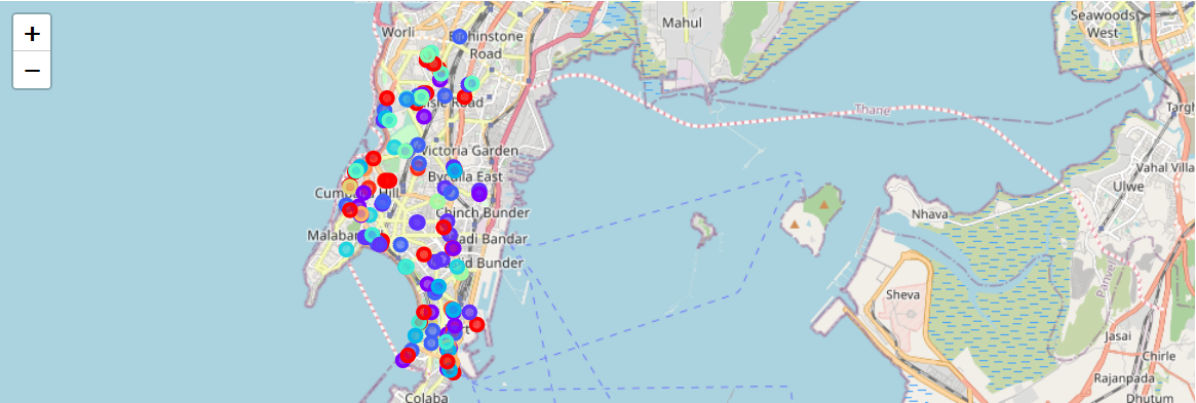

Each colored marker represents a different type of eatery to choose from. Additionally we also print a complete list of each cluster for ease of the user.

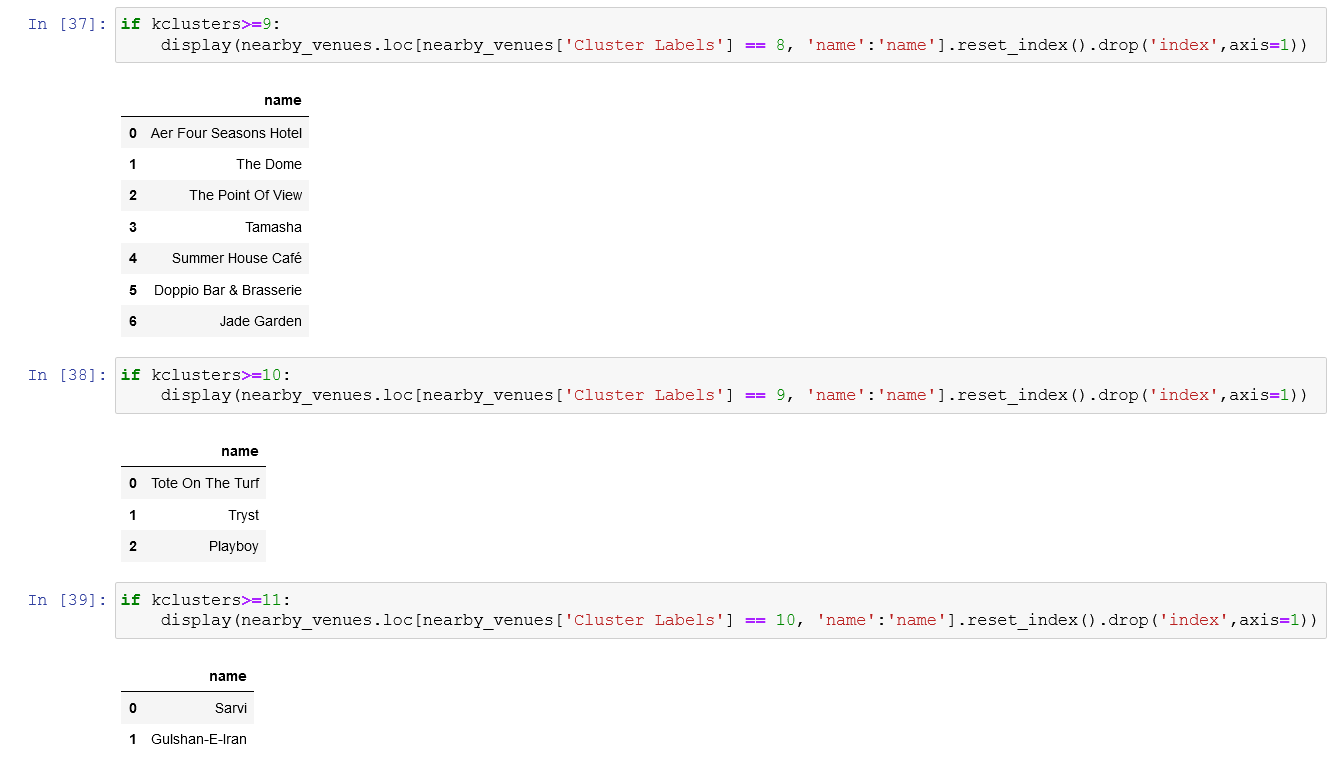

<h2 align='center'>E. Discussion </h2>

We can make recommendations based on the above categories to our user and save them time and effort in looking into a huge list just to find a place to eat.

Additionally we can also further look out to include cities with same names but different locations or we can next use even more complex alorithms like DBSCAN to if we want to increase the complexity of the product.

<h2 align='center'>F. Conclusion </h2>

The project concluded successfully in getting automated inference about the inquired city for its users and helped in categorizing the nearby eateries distinctively.